In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

In [14]:
callbacks = [EarlyStopping(patience=3, monitor='loss')]

In [23]:
def plot_data(y_true, y_predict):
  plt.figure(figsize=(12,5))
  plt.plot(range(len(y_true)),y_true)
  plt.plot(range(len(y_predict)),y_predict)
  plt.legend(["ACT", "PRE"])
  plt.show()

In [5]:
def data_processing(data: pd.DataFrame,window: int = 7):
    data = data[['Open','High','Low','Close']].copy()
    data.dropna(inplace=True)
    y = data.Close.shift(periods=-window)
    y=np.array(y[:-window],dtype=float)
    y = y.reshape(-1,1)
    # converting the value in X and Y form
    scaler_x = MinMaxScaler(feature_range = (0.01, 1.01))
    data = scaler_x.fit_transform(data)
    x=[]
    for i in range(window,len(data)+1):
        x.append(data[i-window:i])
    return np.array(x[:len(y)]),y

In [9]:
data = pd.read_csv("Data/ADANIPORTS.csv", parse_dates=True, index_col='Date')
data.dropna(inplace=True)
data.sort_index(inplace=True)
# data preprocessing

In [10]:
x,y = data_processing(data)

In [11]:
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

In [15]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(x, y, test_size=0.3)
X_val_merged, X_test_merged, Y_val_merged, Y_test_merged = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [18]:
Y_test_merged_inverse = scaler_y.inverse_transform(Y_test_merged)
Y_val_merged_inverse = scaler_y.inverse_transform(Y_val_merged)

In [13]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, return_sequences=True, input_shape=(7,4)))
lstm_model.add(LSTM(8, return_sequences=True))
lstm_model.add(LSTM(8))
lstm_model.add(Dense(1, activation='relu'))
lstm_model.compile(optimizer='adam', loss=MeanSquaredError())
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             4736      
                                                                 
 lstm_1 (LSTM)               (None, 7, 8)              1312      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 6,601
Trainable params: 6,601
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm_model.fit(X_train, Y_train,
          epochs=30,
          callbacks = callbacks,
          validation_data=(X_val_merged, Y_val_merged))

Epoch 1/30
27/27 [==============================] - 13s 82ms/step - loss: 0.1340 - val_loss: 0.0261
Epoch 2/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0202 - val_loss: 0.0112
Epoch 3/30
27/27 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0023
Epoch 4/30
27/27 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 5/30
27/27 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 6/30
27/27 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/30
27/27 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/30
27/27 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 9/30
27/27 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/30
27/27 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 11

In [20]:
lstm_model_prediction = lstm_model.predict(X_test_merged)
lstm_model_prediction = scaler_y.inverse_transform(np.array(lstm_model_prediction).reshape(-1,1))

6/6 [==============================] - 3s 313ms/step


In [21]:
print("Model testing Evaluation")
print(f"Mean Absolute Error: {mean_absolute_error(Y_test_merged_inverse, lstm_model_prediction)}")
print(f"Mean Square Error: {mean_squared_error(Y_test_merged_inverse, lstm_model_prediction)}")
print(f"Root Mean Square Error: {mean_squared_error(Y_test_merged_inverse, lstm_model_prediction, squared=False)}")
print(f"R2 score: {r2_score(Y_test_merged_inverse, lstm_model_prediction)}")

Model testing Evaluation
Mean Absolute Error: 21.243651031345017
Mean Square Error: 868.3788865205457
Root Mean Square Error: 29.468269147008716
R2 score: 0.9771449275136279


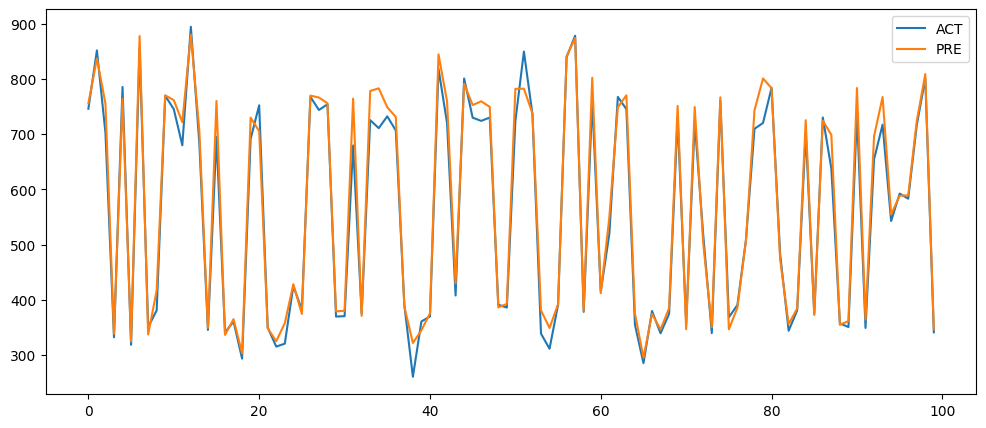

In [24]:
plot_data(Y_test_merged_inverse[:100], lstm_model_prediction[:100])